# Generative Adversarial Networks (GANs)
**Objective:** Understand and implement a simple GAN using PyTorch.

Generative Adversarial Networks (GANs) are deep learning models that can generate new, realistic data samples such as images, videos, and text. GANs consist of two neural networks — a **Generator** and a **Discriminator** — that compete against each other in a game-theoretic setup.

## What is a GAN?

A GAN consists of two main components:

- **Generator (G):** Learns to generate fake data from random noise.
- **Discriminator (D):** Learns to distinguish between real and fake data.

The training process is adversarial:
1. The generator tries to fool the discriminator.
2. The discriminator tries to correctly classify real vs. fake data.

Mathematically, the GAN objective is:

\[
$ \min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_{\text{data}}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(z)))] $
\]

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


## Step 1: Data Preparation

We’ll use the **MNIST dataset** — a collection of handwritten digits (0–9) — as our real data source.

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 128
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████████████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:01<00:00, 6.13MB/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|███████████████████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 677kB/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████████████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 3.83MB/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████████████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 1.14MB/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



## Step 2: Define the Generator and Discriminator

### Generator (G)
- Takes random noise as input.
- Outputs a fake image (28×28 pixels).

### Discriminator (D)
- Takes an image as input.
- Outputs a single probability (real or fake).


In [3]:
# Generator Network
class Generator(nn.Module):
    def __init__(self, input_dim=100, hidden_dim=256, output_dim=784):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, hidden_dim*2),
            nn.ReLU(True),
            nn.Linear(hidden_dim*2, hidden_dim*4),
            nn.ReLU(True),
            nn.Linear(hidden_dim*4, output_dim),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=256):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim*4, hidden_dim*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim*2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


## Step 3: Initialize Models, Optimizers, and Loss Function
We use Binary Cross Entropy (BCE) loss since GAN is a binary classification setup.


In [4]:
z_dim = 100

G = Generator(input_dim=z_dim).to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
lr = 0.0002

optimizer_G = optim.Adam(G.parameters(), lr=lr)
optimizer_D = optim.Adam(D.parameters(), lr=lr)


## Step 4: Training the GAN

1. Train the **Discriminator** to distinguish real and fake images.
2. Train the **Generator** to fool the Discriminator.


In [6]:
epochs = 30

for epoch in range(epochs):
    for i, (real_images, _) in enumerate(dataloader):
        batch_size = real_images.size(0)
        real_images = real_images.view(batch_size, -1).to(device)

        # Labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # --- Train Discriminator ---
        z = torch.randn(batch_size, z_dim).to(device)
        fake_images = G(z)

        outputs_real = D(real_images)
        outputs_fake = D(fake_images.detach())

        d_loss_real = criterion(outputs_real, real_labels)
        d_loss_fake = criterion(outputs_fake, fake_labels)
        d_loss = d_loss_real + d_loss_fake

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # --- Train Generator ---
        z = torch.randn(batch_size, z_dim).to(device)
        fake_images = G(z)
        outputs = D(fake_images)

        g_loss = criterion(outputs, real_labels)  # Generator wants D to believe fake is real

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")


Epoch [1/30] | D Loss: 0.0054 | G Loss: 7.3310
Epoch [2/30] | D Loss: 1.2678 | G Loss: 8.3659
Epoch [3/30] | D Loss: 0.6599 | G Loss: 8.4241
Epoch [4/30] | D Loss: 2.2225 | G Loss: 1.3533
Epoch [5/30] | D Loss: 1.1882 | G Loss: 4.3140
Epoch [6/30] | D Loss: 0.8055 | G Loss: 1.1242
Epoch [7/30] | D Loss: 0.1721 | G Loss: 4.0201
Epoch [8/30] | D Loss: 0.2193 | G Loss: 4.2865
Epoch [9/30] | D Loss: 0.0497 | G Loss: 6.9426
Epoch [10/30] | D Loss: 0.5980 | G Loss: 4.5984
Epoch [11/30] | D Loss: 0.4507 | G Loss: 6.2350
Epoch [12/30] | D Loss: 0.2797 | G Loss: 6.4115
Epoch [13/30] | D Loss: 0.2032 | G Loss: 4.5084
Epoch [14/30] | D Loss: 0.4240 | G Loss: 6.9540
Epoch [15/30] | D Loss: 0.1621 | G Loss: 9.7538
Epoch [16/30] | D Loss: 0.4017 | G Loss: 4.1586
Epoch [17/30] | D Loss: 0.3477 | G Loss: 5.7893
Epoch [18/30] | D Loss: 0.0782 | G Loss: 6.6444
Epoch [19/30] | D Loss: 0.2728 | G Loss: 9.9649
Epoch [20/30] | D Loss: 0.4581 | G Loss: 3.9620
Epoch [21/30] | D Loss: 0.1780 | G Loss: 6.2195
E

## Step 5: Visualize Generated Images

Let's view some generated samples from the generator after training.


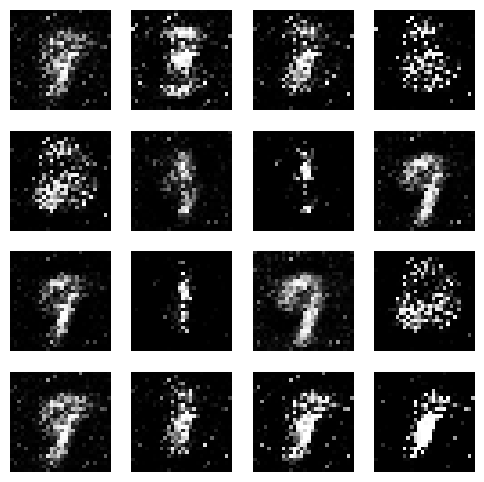

In [7]:
def show_images(images, n=16):
    plt.figure(figsize=(6,6))
    for i in range(n):
        plt.subplot(4, 4, i+1)
        plt.imshow(images[i].reshape(28,28).cpu().detach(), cmap='gray')
        plt.axis('off')
    plt.show()

# Generate fake images
z = torch.randn(16, z_dim).to(device)
fake_images = G(z)
show_images(fake_images)


## Step 6: Notes & Best Practices

- **Training Stability:** GANs can be hard to train. Use techniques like:
  - Label smoothing (real = 0.9 instead of 1.0)
  - Gradient penalty
  - Batch normalization in the Generator
  - Leaky ReLU in Discriminator

- **Common GAN Variants:**
  - DCGAN: Deep Convolutional GAN for images
  - WGAN: Wasserstein GAN for stable training
  - CycleGAN: Image-to-image translation
  - StyleGAN: High-resolution image synthesis

- **Applications:**
  - Image generation, super-resolution
  - Data augmentation
  - Creative AI (art, fashion, design)
  - Anomaly detection
